<a href="https://colab.research.google.com/github/ishandas387/Language-Model-For-Odia/blob/master/LSTM_%26_Transformer_Language_model_Odia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

imports and installs thats needed


In [1]:
!pip install chart_studio
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from bs4 import BeautifulSoup
import chart_studio as cs
#import plotly.graph_objs as go
#import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot



     |████████████████████████████████| 71kB 3.4MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Check the GPU

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data

In [3]:
df = pd.read_csv('odia_news_sambad_headlines_balance.csv')
df.head()

,headings,label
0,ନୂଆପଡ଼ାର ମାଓପ୍ରବଣ ୮ଟି ପଞ୍ଚାୟତରେ ଥିବା ଅସ୍ଥାୟୀ ସ...,state
1,"ରାଜ୍ୟର ସୀମା ଜଗିବା ଦୁଃସାଧ୍ୟ, ପଞ୍ଚାୟତମାନେ ଚାହିଁ...",state
2,ଶଙ୍କରାଚାର୍ଯ୍ୟଙ୍କୁ ଭେଟି ସ୍ନାନଯାତ୍ରାକୁ ନିମନ୍ତ୍ର...,state
3,ରାଜ୍ୟର ଆର୍ଥିକ ସ୍ଥିତି ଉପରେ କରୋନା ମାଡ଼ : କେନ୍ଦ୍...,state
4,କଟକ ବଡ଼ ଡାକ୍ତରଖାନା ହେବ ବିଶ୍ୱସ୍ତରୀୟ : କ୍ୱାର୍ଟର୍...,state


## Preprocessing

Cleaining, shuffling stuff

In [4]:
def to_label(label):
  label = str(label)
  if label == 'state':
    return 0
  elif label == 'sports':
    return 1
  else: 
    return 2

df['label'] = df.label.apply(to_label)
df.head()
df['label'].value_counts()

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

import string

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def odia_num_remove(text):
  text_new = ""
  odia_num =['୦',         
  '୧',	
	'୨',	
	'୩',	
	'୪',	
	'୫',	
	'୬',	
	'୭',	
	'୮',	
	'୯',
  '‘',
  '’']
  for char in text:
    if char not in odia_num:
      text_new = text_new + char
  return text_new


,headings,label
0,ନୂଆପଡ଼ାର ମାଓପ୍ରବଣ ୮ଟି ପଞ୍ଚାୟତରେ ଥିବା ଅସ୍ଥାୟୀ ସ...,0
1,"ରାଜ୍ୟର ସୀମା ଜଗିବା ଦୁଃସାଧ୍ୟ, ପଞ୍ଚାୟତମାନେ ଚାହିଁ...",0
2,ଶଙ୍କରାଚାର୍ଯ୍ୟଙ୍କୁ ଭେଟି ସ୍ନାନଯାତ୍ରାକୁ ନିମନ୍ତ୍ର...,0
3,ରାଜ୍ୟର ଆର୍ଥିକ ସ୍ଥିତି ଉପରେ କରୋନା ମାଡ଼ : କେନ୍ଦ୍...,0
4,କଟକ ବଡ଼ ଡାକ୍ତରଖାନା ହେବ ବିଶ୍ୱସ୍ତରୀୟ : କ୍ୱାର୍ଟର୍...,0


0    6981
1    6967
2    6792
Name: label, dtype: int64

In [5]:
test_string="t're is, a test! www.googfle.com\ // #test"
test_string = remove_URL(test_string)
test_string = remove_html(test_string)
print(remove_punct(test_string))

tre is a test   test


In [6]:
print(df.head(1))

                                            headings  label
0   ନୂଆପଡ଼ାର ମାଓପ୍ରବଣ ୮ଟି ପଞ୍ଚାୟତରେ ଥିବା ଅସ୍ଥାୟୀ ସ...      0


In [7]:
df["headings"] = df.headings.map(lambda x: remove_URL(x))
df["headings"] = df.headings.map(lambda x: remove_html(x))
df["headings"] = df.headings.map(lambda x: remove_punct(x))
df["headings"] = df.headings.map(lambda x: odia_num_remove(x))


#Using regex with .str.findall and .str.join appears to be fastest:

#df['headings'] = df['headings'].str.findall('\w{3,}').str.join(' ')
df['headings'] = df['headings'].str.split().map(lambda sl: " ".join(s for s in sl if len(s) > 3))


df.head(10)

,headings,label
0,ନୂଆପଡ଼ାର ମାଓପ୍ରବଣ ପଞ୍ଚାୟତରେ ଥିବା ଅସ୍ଥାୟୀ ସ୍ବାସ୍...,0
1,ରାଜ୍ୟର ସୀମା ଜଗିବା ଦୁଃସାଧ୍ୟ ପଞ୍ଚାୟତମାନେ ଚାହିଁଲେ...,0
2,ଶଙ୍କରାଚାର୍ଯ୍ୟଙ୍କୁ ଭେଟି ସ୍ନାନଯାତ୍ରାକୁ ନିମନ୍ତ୍ରଣ...,0
3,ରାଜ୍ୟର ଆର୍ଥିକ ସ୍ଥିତି ଉପରେ କରୋନା ମାଡ଼ କେନ୍ଦ୍ର ଟ...,0
4,ଡାକ୍ତରଖାନା ବିଶ୍ୱସ୍ତରୀୟ କ୍ୱାର୍ଟର୍ସ ହେଲେ ବିଜୁଳିପ...,0
5,ବ୍ରହ୍ମପୁରରେ ଆଜିଠୁ ଦିନିଆ ସଟ୍‌ଡାଉନ୍ ବଜାରରେ ଅସମ୍ଭ...,0
6,ବିଜୟ କେତନଙ୍କ ଘରୋଇ ବ୍ୟାଙ୍କ ଅଧିକାରୀଙ୍କୁ ଜାମିନ,0
7,ବଲ୍‌ ସୁପ୍ରିମକୋର୍ଟରେ ପ୍ରଫୁଲ୍ଲ ଘଡ଼େଇ,0
8,ଆଇଆଇଏମ୍‌ ସମ୍ବଲପୁରରେ ଜାତୀୟ ସମ୍ମିଳନୀ ଉଦ୍‌ଘାଟିତ ହ...,0
9,ପହଞ୍ଚିବ ଗୋଟିଏ ଶ୍ରମିକ ଟ୍ରେନ୍‌,0


In [8]:
df['label'].value_counts()

0    6981
1    6967
2    6792
Name: label, dtype: int64

In [9]:
#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,headings,label
0,ଭାରତୀୟ ଟେଷ୍ଟ୍‌ ଘୋଷିତ ରାହୁଲ ବାଦ୍ ଶୁଭମନ୍‌ଙ୍କୁ ସ...,1
1,ମୁଦ୍ରା ଝଟ୍‌କା ଏନ୍‌ପିଏ ବୃଦ୍ଧିକୁ ଚିନ୍ତା ପ୍ରକଟ ଆର...,2
2,ବିଶ୍ୱ ବଜାରରେ ଡଲାରକୁ କମିଲା ସର୍ବନିମ୍ନ,2
3,ରାଜଧାନୀରେ ସମସ୍ତ ପାର୍କକୁ ମାର୍ଚ୍ଚ ଯାଏଁ ବନ୍ଦ ରଖିବ...,0
4,ଆଣ୍ଡାମାନ ନିକୋବର ଦ୍ଵୀପପୁଞ୍ଜରୁ ଫେରିଲେ ଓଡ଼ିଆ,0
5,କିମ୍ବଦନ୍ତୀ କପିଳ ଦେବଙ୍କୁ ଗଲ୍‌ଫ ଟ୍ରଫି,1
6,ବିଜୟ ହଜାରେ ଟ୍ରଫି ପରାଜୟ ଓଡ଼ିଶା ଅଭିଯାନ,1
7,ଅର୍ଥନୈତିକ ସର୍ଭେ ରିପୋର୍ଟ ଅଭିବୃଦ୍ଧି ଦେଶଠୁ ଅଧିକ,2
8,ଆଇପିଏଲ୍‌ ପାଇଁ ରିଲାଏନ୍ସ ଜିଓର ମିଳିବ ଜିବିର ଡାଟା,2
9,ଭାରତକୁ ଜାତିସଂଘରେ ସମାଲୋଚନା ମହଙ୍ଗା ପଡ଼ିବ ତୁର୍କୀ ...,2


In [10]:
df['label'].value_counts()

0    6981
1    6967
2    6792
Name: label, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20740 entries, 0 to 20739
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headings  20740 non-null  object
 1   label     20740 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 324.2+ KB


In [12]:
from collections import Counter

# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [13]:
text = df['headings']

counter = counter_word(text)

In [14]:
len(counter)

27858

6.825120540019286

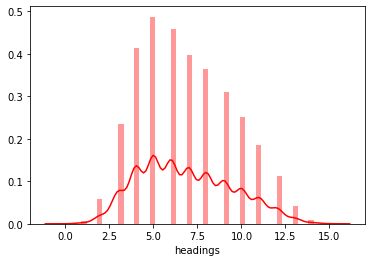

In [15]:
colum_len = df["headings"].str.len()

#this is just the string length not word count
max_value = colum_len.max()
#max_value

#word count 

word_c =  df['headings'].str.split().str.len()
word_c.mean()
sns.distplot(word_c, color='red')


In [ ]:
from gensim.models.fasttext import FastText

## Text to sequence

In [16]:
## define word embedding props
# max number of words to keep
# embedding dimenssion
# max seq length

MAX_NB_WORDS = 15000
#the average word length of heading is taken as max seq
MAX_SEQ_LENGTH = 12
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS,split=" ", oov_token='<OOV>')
tokenizer.fit_on_texts(df['headings'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens'% len(word_index))

X = tokenizer.texts_to_sequences(df['headings'].values)
X = pad_sequences(X,maxlen=MAX_SEQ_LENGTH,padding="post", truncating="post")
Y = pd.get_dummies(df['label']).values
print(Y)


Found 27859 unique tokens
[[0 1 0]
 [0 0 1]
 [0 0 1]
 ...
 [0 0 1]
 [1 0 0]
 [0 1 0]]


## FastText word embedding here

The FastText word embedding is loaded here from gDrive.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [18]:
import os, re, csv, math, codecs

In [19]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/content/drive/My Drive/collab_dataset/cc.or.300.vec', encoding='utf-8')
for line in (f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 324930 word vectors


In [20]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, 300))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 5609


In [ ]:
# test the sequencing # reversing

print(X[51])

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])
print(decode(X[51
]))

[ 926 1119 3510 4819  552 2807    0    0    0    0    0    0]
ରାଉରକେଲାରେ ଲିଟର ଚୋରା ବୋଲେରୋ ଅଭିଯୁକ୍ତ ଫେରାର୍ ? ? ? ? ? ?


## Creating 5 dataset of 500 data each for Test

This is for testing and evaluating model

This data is deleted from X and Y on which the model will be trained.

Hence the models will be tested on this 5 datatsets separately. The models are not trained on these sets.

X Y -> original dataset ~14K records
X_test, Y_test -> Test split from X and Y 80-20


X1_test , Y1_test new subsets from X and Y ~500 records which are not part of X and Y while training.
Same for X2_test .... X5_test.

In [21]:
X[0]
X.shape
Y.shape

array([   20,   106,  1186,   665,  1017, 11622,   316,     0,     0,
           0,     0,     0], dtype=int32)

(20740, 12)

(20740, 3)

In [22]:
#extract 5 sets of data as testset for evaluating model
X1_test = X[0:501]
X = np.delete(X,np.s_[0:501], axis=0)
Y1_test = Y[0:501]
Y = np.delete(Y,np.s_[0:501], axis=0)
X.shape
Y.shape



(20239, 12)

(20239, 3)

In [23]:
X.shape
X1_test.shape
X1_test[0]
print("--")
X[0]

(20239, 12)

(501, 12)

array([   20,   106,  1186,   665,  1017, 11622,   316,     0,     0,
           0,     0,     0], dtype=int32)

--


array([   23,   689, 12048, 12049, 12050,  1020,    43,     0,     0,
           0,     0,     0], dtype=int32)

In [24]:
X2_test = X[0:501]
X = np.delete(X,np.s_[0:501], axis=0)
Y2_test = Y[0:501]
Y = np.delete(Y,np.s_[0:501], axis=0)
X.shape
Y.shape

(19738, 12)

(19738, 3)

In [25]:
X.shape
X2_test.shape
X2_test[0]
print("--")
X[0]

(19738, 12)

(501, 12)

array([   23,   689, 12048, 12049, 12050,  1020,    43,     0,     0,
           0,     0,     0], dtype=int32)

--


array([ 8112,  6175,   468, 12433,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [26]:
X3_test = X[0:501]
X = np.delete(X,np.s_[0:501], axis=0)
Y3_test = Y[0:501]
Y = np.delete(Y,np.s_[0:501], axis=0)
X.shape
Y.shape

(19237, 12)

(19237, 3)

In [27]:
X.shape
X3_test.shape
X3_test[0]
print("--")
X[0]

(19237, 12)

(501, 12)

array([ 8112,  6175,   468, 12433,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=int32)

--


array([ 1394, 12852,  6287, 12853,    89,   393,     0,     0,     0,
           0,     0,     0], dtype=int32)

In [28]:
X4_test = X[0:501]
X = np.delete(X,np.s_[0:501], axis=0)
Y4_test = Y[0:501]
Y = np.delete(Y,np.s_[0:501], axis=0)
X.shape
Y.shape

X.shape
X4_test.shape
X4_test[0]
print("--")
X[0]

(18736, 12)

(18736, 3)

(18736, 12)

(501, 12)

array([ 1394, 12852,  6287, 12853,    89,   393,     0,     0,     0,
           0,     0,     0], dtype=int32)

--


array([ 8435,  5193, 13224,   123,  8436, 13225,  3289,   585,   557,
           0,     0,     0], dtype=int32)

In [29]:
X5_test = X[0:501]
X = np.delete(X,np.s_[0:501], axis=0)
Y5_test = Y[0:501]
Y = np.delete(Y,np.s_[0:501], axis=0)
X.shape
Y.shape

X.shape
X5_test.shape
X5_test[0]
print("--")
X[0]

(18235, 12)

(18235, 3)

(18235, 12)

(501, 12)

array([ 8435,  5193, 13224,   123,  8436, 13225,  3289,   585,   557,
           0,     0,     0], dtype=int32)

--


array([  23, 1650,  539, 4911,  128, 1279,   12,   43,    0,    0,    0,
          0], dtype=int32)

## Split

Splitting 80 -20 .
and splitting one reduced size dataset as well just in case for quick run.

---
X_train_r

---


In [30]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size= 0.2, random_state= 50)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(14588, 12)
(14588, 3)
(3647, 12)
(3647, 3)


# Build Model - LSTM



## Displaying history functions


## Imports


In [32]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import math

## Helper functions

### Graph functions

In [33]:
# display the train loss graph from history
from matplotlib import pyplot

def display_history_loss(history, model_name):
  
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('model train vs validation loss {}'.format(model_name))
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')
  pyplot.show()

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  


### Precision Recall F1 functions

In [34]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

## evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)


### Basic print function

In [35]:
def print_stats(f1,precision, recall, acc):
  print("#######################################################")
  print("F1        : {}".format(f1))
  print("Precision : {}".format(precision))
  print("Recall    : {}".format(recall))
  print("Accuracy  : {}".format(acc))
  print("#######################################################")
  
  

### Step decay function

Although not used currently. Can be used for gradual manipulation of learning rate.

In [ ]:
def step_decay(epoch):
  initial_lrate = 0.1
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
  return lrate


## Model 1 LSTM 
32/64 or node param - tanh - 0.1 dropout
Dense layer -3 - softmax




There is no final, definite, rule of thumb on how many nodes (or hidden neurons) or how many layers one should choose, and very often a trial and error approach will give you the best results for your individual problem. The most common framework for this is most likely the k-fold cross-validation. However, even for a testing procedure, we need to choose some (k) numbers of nodes.
The following formula may give you a starting point:
Image for post

![alt text](https://miro.medium.com/max/228/1*9jY98E1ndGBcob6GypYM1Q.png)

Nᵢ is the number of input neurons, Nₒ the number of output neurons, Nₛ the number of samples in the training data, and α represents a scaling factor that is usually between 2 and 10. We can calculate 8 different numbers to feed into our validation procedure and find the optimal model, based on the resulting validation loss.

Keras Embedding Layer
Keras offers an Embedding layer that can be used for neural networks on text data.

---
It requires that the input data be integer encoded, so that each word is represented by a unique integer.


This data preparation step can be performed using 
the Tokenizer API also provided with Keras.

---




In [36]:
def custom_evaluate(model, X, Y):
    loss, acc, f1_score, precision, recall = model.evaluate(X, Y,  verbose=0 )
    print("-------------------------------------")
    print_stats(f1_score, precision, recall, acc)

In [ ]:
def single_lstm(nodes, **kwargs):
  #as declared above earlier
  MAX_NB_WORDS = 15000
  EMBEDDING_DIM = 100
  MAX_SEQ_LENGTH = 12
  with tf.device('/device:GPU:0'):
    model = Sequential()

    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH))
    model.add(LSTM(nodes, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout')))
  
    model.add(Dense(3, activation= kwargs.get('dense_actv')))
    optimizer = Adam(learning_rate=1e-5)
    # Since one hot encoded. categoriacl crossentropy will work
    #model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])
    
    model.summary()
    filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    # learning rate decay
    # not being used currently
    lrate = LearningRateScheduler(step_decay)
    history = model.fit(kwargs.get('X_train'),
                        kwargs.get('Y_train'), 
                        epochs= kwargs.get('epochs'), 
                        batch_size = 100,
                        callbacks= [es],
                        validation_data=(kwargs.get('X_test'),
                                         kwargs.get('Y_test')),)
    display_history_loss(history, "single_lstm")
    plot_graphs(history, "acc")
    #score = model.evaluate(X_test, Y_test)
    
        
    loss, acc, f1_score, precision, recall = model.evaluate(X_test, Y_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    loss, acc, f1_score, precision, recall = model.evaluate(X1_test, Y1_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    loss, acc, f1_score, precision, recall = model.evaluate(X2_test, Y2_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    loss, acc, f1_score, precision, recall = model.evaluate(X3_test, Y3_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    loss, acc, f1_score, precision, recall = model.evaluate(X4_test, Y4_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    loss, acc, f1_score, precision, recall = model.evaluate(X5_test, Y5_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    
    #print(score[0])
    #print(score[1])
    #print(score)

### Result

So far the best has been noted with 64 node lstm with softmax dense activation.
100 epochs. Batch size 100. Data 19K
Validation loss on evaluate 0.7
Accuracy 0.88
Running time 599.544s


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 12, 100)           1500000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 1,542,435
Trainable params: 1,542,435
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 16592 samples, validate on 4148 samples
Epoch 1/100
16592/16592 [==============================] - 6s 346us/step - loss: 1.0987 - acc: 0.3400 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0979 - val_acc: 0.3715 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
16592/16592 [==============================] - 5s 318us/step - loss: 1.0968 - acc: 0.3707 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0958 - val_acc: 0.3645 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
16592/16592 [==============================] - 5s 313us/step - loss: 1.0948 - acc: 0.3728 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0938 - val_acc: 0.3732 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
16592/16592 [==============================] - 5s 323us/step - loss: 1.0926 - 

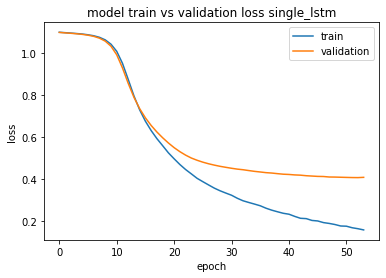

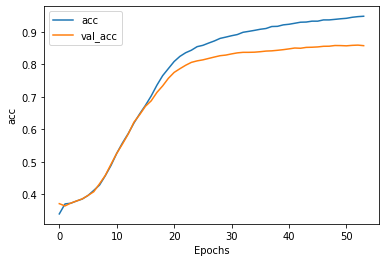

#######################################################
F1        : 0.8583707213401794
Precision : 0.8629058003425598
Recall    : 0.8540384769439697
Accuracy  : 0.8572806119918823
#######################################################


In [ ]:
single_lstm(64, activation = 'tanh', 
            dropout = 0.2, 
            dense_actv ='softmax',
            epochs =100,
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 100)           1500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,542,435
Trainable params: 1,542,435
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 16592 samples, validate on 4148 samples
Epoch 1/100
16592/16592 [==============================] - 10s 611us/step - loss: 1.0978 - acc: 0.3525 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0967 - val_acc: 0.3616 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
16592/16592 [==============================] - 8s 484us/step - loss: 1.0960 - acc: 0.3597 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0948 - val_acc: 0.3635 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
16592/16592 [==============================] - 8s 476us/step - loss: 1.0940 - acc: 0.3674 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0928 - val_acc: 0.3703 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
16592/16592 [==============================] - 8s 478us/step - loss: 1.0916 -

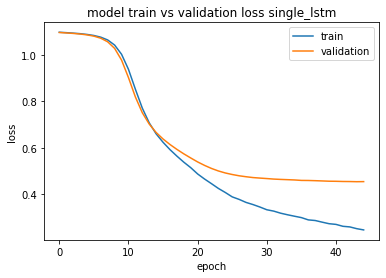

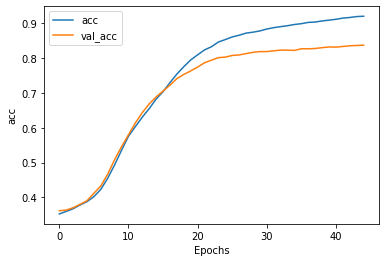

#######################################################
F1        : 0.8367220759391785
Precision : 0.8418501615524292
Recall    : 0.83182692527771
Accuracy  : 0.8370298743247986
#######################################################


In [ ]:
single_lstm(64, activation = 'tanh', 
            dropout = 0.2, 
            dense_actv ='softmax',
            epochs =100,
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 12, 100)           1500000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 195       
Total params: 1,542,435
Trainable params: 1,542,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
146/146 [==============================] - 3s 21ms/step - loss: 1.0985 - acc: 0.3471 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0975 - val_acc: 0.3587 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
146/146 [==============================] - 3s 18ms/step - loss: 1.0968 - acc: 0

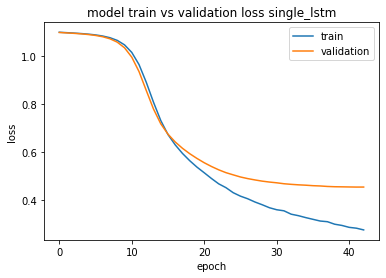

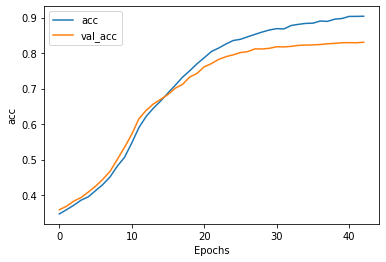

#######################################################
F1        : 0.8285017013549805
Precision : 0.8373762965202332
Recall    : 0.820104718208313
Accuracy  : 0.8305456638336182
#######################################################
#######################################################
F1        : 0.8118409514427185
Precision : 0.8185741901397705
Recall    : 0.8054315447807312
Accuracy  : 0.8183632493019104
#######################################################
#######################################################
F1        : 0.8004471659660339
Precision : 0.8074524402618408
Recall    : 0.7938057780265808
Accuracy  : 0.8003991842269897
#######################################################
#######################################################
F1        : 0.8163231611251831
Precision : 0.8235940933227539
Recall    : 0.8094307780265808
Accuracy  : 0.8183632493019104
#######################################################
#######################################################
F

In [ ]:
with tf.device('/device:GPU:0'):
  
  single_lstm(64, activation = 'tanh', 
              dropout = 0.2, 
              dense_actv ='softmax',
              epochs =100,
              X_train = X_train,
              Y_train = Y_train,
              X_test = X_test,
              Y_test = Y_test)

## Model 2 double layer LSTM 

In [ ]:
def double_lstm(nodes, **kwargs):
  #as declared above earlier
  MAX_NB_WORDS = 15000
  EMBEDDING_DIM = 100
  MAX_SEQ_LENGTH = 12
  with tf.device('/device:GPU:0'):
    model_d = Sequential()

    model_d.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH))
    model_d.add(LSTM(nodes, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout'), return_sequences=True ))
    model_d.add(LSTM(32, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout') ))
    #model_d.add(Dense(30,activation= kwargs.get('dense_actv')))
    model_d.add(Dense(3, activation= kwargs.get('dense_actv')))

    optimizer = Adam(learning_rate=1e-5)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    model_d.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=['acc',f1_m,precision_m, recall_m])
    model_d.summary()
    history = model_d.fit(kwargs.get('X_train'), 
                        kwargs.get('Y_train'), 
                        epochs= kwargs.get('epochs'), 
                        callbacks=[es],
                        batch_size = 100,
                        validation_data=(kwargs.get('X_test'), kwargs.get('Y_test')),)
    display_history_loss(history, "double_lstm")
    plot_graphs(history, "acc")
    custom_evaluate(model_d, X_test, Y_test)
    custom_evaluate(model_d, X1_test, Y1_test)
    custom_evaluate(model_d, X2_test, Y2_test)
    custom_evaluate(model_d, X3_test, Y3_test)
    custom_evaluate(model_d, X4_test, Y4_test)
    custom_evaluate(model_d, X5_test, Y5_test)
   

    #loss, acc, f1_score, precision, recall = model.evaluate(X_test, Y_test,  verbose=0 )
    #print_stats(f1_score, precision, recall, acc)
    


### Result

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 12, 100)           1500000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 12, 32)            17024     
_________________________________________________________________
lstm_16 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_53 (Dense)             (None, 3)                 99        
Total params: 1,525,443
Trainable params: 1,525,443
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
146/146 [==============================] - 4s 25ms/step - loss: 1.0980 - acc: 0.3682 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0972 - val_acc: 0.4110 - val_f1_m: 0.0000e+00 - val_precision_

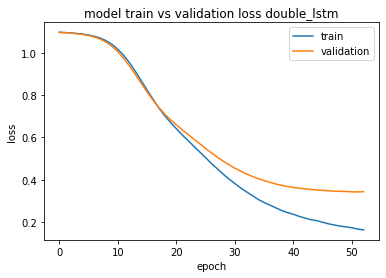

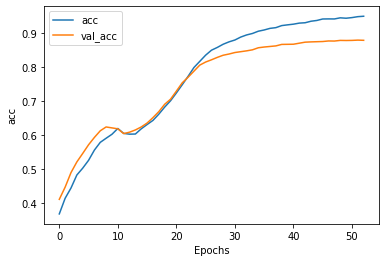

-------------------------------------
#######################################################
F1        : 0.8801215887069702
Precision : 0.8890783190727234
Recall    : 0.8716486096382141
Accuracy  : 0.8785303235054016
#######################################################
-------------------------------------
#######################################################
F1        : 0.8787760138511658
Precision : 0.8840957880020142
Recall    : 0.8737909197807312
Accuracy  : 0.8802395462989807
#######################################################
-------------------------------------
#######################################################
F1        : 0.8606380820274353
Precision : 0.866091251373291
Recall    : 0.85546875
Accuracy  : 0.8622754216194153
#######################################################
-------------------------------------
#######################################################
F1        : 0.8676880598068237
Precision : 0.8734123110771179
Recall    : 0.8621651530265808


In [ ]:
double_lstm(32, activation = 'tanh',  
            dense_actv ='softmax',
            epochs =100, 
            dropout=0.2,
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

## Model 3 bidirectional LSTM


The Bidirectional wrapper is used with a LSTM layer, this propagates the input forwards and backwards through the LSTM layer and then concatenates the outputs. This helps LSTM to learn long term dependencies. We then fit it to a dense neural network to do classification.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

In [ ]:
model_bi = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    #tf.keras.layers.Dense(30, activation='softmax'),
    # Add a Dense layer with 3 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_bi.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         1500000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                34048     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 1,534,243
Trainable params: 1,534,243
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model2.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
model_bi.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
with tf.device('/device:GPU:0'):
   history2 = model_bi.fit(
      X_train, Y_train, epochs=60,batch_size = 100,callbacks=[es], validation_data=(X_test, Y_test),
  )


Epoch 1/60
198/198 [==============================] - 4s 22ms/step - loss: 1.0961 - acc: 0.4414 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0941 - val_acc: 0.4906 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/60
198/198 [==============================] - 4s 18ms/step - loss: 1.0923 - acc: 0.4822 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0898 - val_acc: 0.5015 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/60
198/198 [==============================] - 4s 18ms/step - loss: 1.0877 - acc: 0.4997 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0847 - val_acc: 0.5233 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/60
198/198 [==============================] - 4s 18ms/step - loss: 1.0821 - acc: 0.5247 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.00

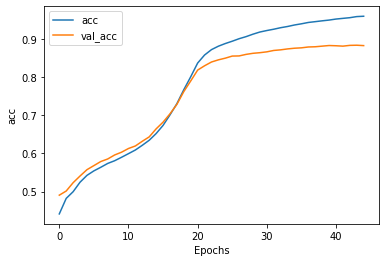

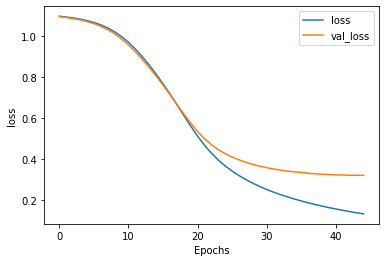

In [ ]:
plot_graphs(history2, "acc")
plot_graphs(history2, "loss")  



In [ ]:
loss, acc, f1_score, precision, recall = model2.evaluate(X_test, Y_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.8840121626853943
Precision : 0.8879507780075073
Recall    : 0.8802322745323181
Accuracy  : 0.8830066919326782
#######################################################


### Result


In [ ]:
#2nd
with tf.device('/device:GPU:0'):
   history2 = model_bi.fit(
      X_train, Y_train, epochs=100,batch_size = 100,callbacks=[es], validation_data=(X_test, Y_test),
  )

Epoch 1/100
146/146 [==============================] - 4s 24ms/step - loss: 1.0961 - acc: 0.3608 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0948 - val_acc: 0.3869 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
146/146 [==============================] - 3s 19ms/step - loss: 1.0934 - acc: 0.3928 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0920 - val_acc: 0.4091 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/100
146/146 [==============================] - 3s 19ms/step - loss: 1.0905 - acc: 0.4057 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0889 - val_acc: 0.4264 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/100
146/146 [==============================] - 3s 20ms/step - loss: 1.0872 - acc: 0.4227 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 

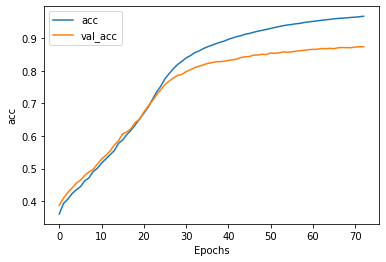

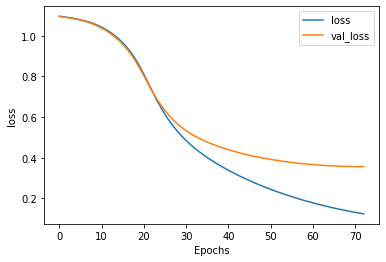

-------------------------------------
#######################################################
F1        : 0.8611730337142944
Precision : 0.8621651530265808
Recall    : 0.8602120280265808
Accuracy  : 0.8602794408798218
#######################################################
-------------------------------------
#######################################################
F1        : 0.8293270468711853
Precision : 0.8316760659217834
Recall    : 0.8271019458770752
Accuracy  : 0.826347291469574
#######################################################
-------------------------------------
#######################################################
F1        : 0.8590028882026672
Precision : 0.8597710132598877
Recall    : 0.8582589030265808
Accuracy  : 0.8602794408798218
#######################################################
-------------------------------------
#######################################################
F1        : 0.8844245672225952
Precision : 0.8861847519874573
Recall    : 0.882719516

In [ ]:
plot_graphs(history2, "acc")
plot_graphs(history2, "loss")  
custom_evaluate(model_bi,X1_test,Y1_test)
custom_evaluate(model_bi,X2_test,Y2_test)
custom_evaluate(model_bi,X3_test,Y3_test)
custom_evaluate(model_bi,X4_test,Y4_test)
custom_evaluate(model_bi,X5_test,Y5_test)


#loss, acc, f1_score, precision, recall = model_bi.evaluate(X_test, Y_test,  verbose=0 )
#print_stats(f1_score, precision, recall, acc)


# Build Model - Transformer


Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers as tfopt

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
maxlen = 12
vocab_size = 15000
#X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
#X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
X_train.shape

(14588, 12)

In [ ]:
X_train[100]

array([ 482,  361, 1547, 1793,    1,  173,    4,  242,    0,    0,    0,
          0], dtype=int32)

In [ ]:
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
#keras.backend.clear_session()
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block =  TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(64, activation="softmax")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_transformer = keras.Model(inputs=inputs, outputs=outputs)

## Result

100 epochs, 100 batch. 19k data training. Dense softmax activation. and extra more layer of danse 20 has given similar kind but better result achieved in LSTM model 1 with 64.

acc 0.898 - better

val_loss 0.7 - similar 

runtime 204.79s - less than half of LSTM model1 

In [ ]:
with tf.device('/device:GPU:0'):
  optimizer_t = tfopt.Adam(learning_rate=1e-5)
  model_transformer.compile(loss="categorical_crossentropy", optimizer=optimizer_t,  metrics=['acc',f1_m,precision_m, recall_m]
)
  model_transformer.summary()
  history_transformer = model_transformer.fit(
      X_train, Y_train, batch_size=100, epochs=100, validation_data=(X_test, Y_test)
  )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
token_and_position_embedding (None, 12, 100)           1501200   
_________________________________________________________________
transformer_block (Transform (None, 12, 100)           47332     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0     

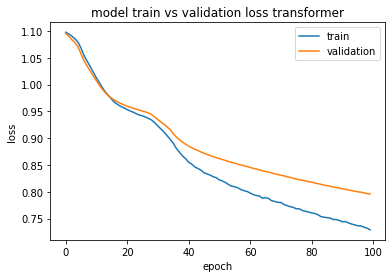

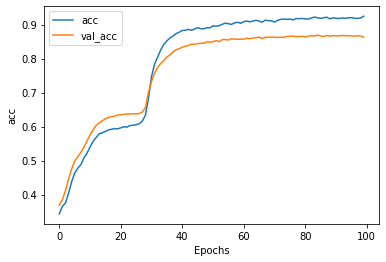

In [ ]:
display_history_loss(history_transformer, "transformer")
plot_graphs(history_transformer, "acc")

In [ ]:
print(X_test.shape)

#score_transformer = model_transformer.evaluate(X_test,Y_test)
#print(score_transformer[0])
#print(score_transformer[1])

loss, acc, f1_score, precision, recall = model_transformer.evaluate(X_test, Y_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)


(3647, 12)
#######################################################
F1        : 0.3864634037017822
Precision : 0.9188242554664612
Recall    : 0.24922184646129608
Accuracy  : 0.8629010319709778
#######################################################


In [ ]:
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X3_test, Y3_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.3748677968978882
Precision : 0.8878427743911743
Recall    : 0.2423735111951828
Accuracy  : 0.8443113565444946
#######################################################


In [ ]:
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X4_test, Y4_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.442914217710495
Precision : 0.9682826399803162
Recall    : 0.2940848171710968
Accuracy  : 0.8642714619636536
#######################################################


In [ ]:
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X5_test, Y5_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.42881742119789124
Precision : 0.9371318221092224
Recall    : 0.2855282723903656
Accuracy  : 0.8662674427032471
#######################################################


In [ ]:
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X1_test, Y1_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.3579476475715637
Precision : 0.8833581805229187
Recall    : 0.2306547611951828
Accuracy  : 0.8483033776283264
#######################################################


In [ ]:
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X2_test, Y2_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.3933693468570709
Precision : 0.9748263955116272
Recall    : 0.2493489533662796
Accuracy  : 0.8582834601402283
#######################################################


In [ ]:
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X_test, Y_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.8395062685012817
Precision : 0.8632296323776245
Recall    : 0.8178365230560303
Accuracy  : 0.8488427996635437
#######################################################


In [ ]:
with tf.device('/device:GPU:0'):
  optimizer_t = tfopt.Adam(learning_rate=1e-5)
  model_transformer.compile(loss="categorical_crossentropy", optimizer=optimizer_t,  metrics=['acc',f1_m,precision_m, recall_m]
)
  model_transformer.summary()
  history_transformer = model_transformer.fit(
      X_train, Y_train, batch_size=100, epochs=100, validation_data=(X_test, Y_test)
  )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
token_and_position_embedding (None, 12, 100)           1501200   
_________________________________________________________________
transformer_block_5 (Transfo (None, 12, 100)           47332     
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)               

In [ ]:
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X_test, Y_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X1_test, Y1_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X2_test, Y2_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X3_test, Y3_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X4_test, Y4_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)
loss, acc, f1_score, precision, recall = model_transformer.evaluate(X5_test, Y5_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)

#######################################################
F1        : 0.42219480872154236
Precision : 0.9080260992050171
Recall    : 0.279410719871521
Accuracy  : 0.8774334788322449
#######################################################
#######################################################
F1        : 0.4247574508190155
Precision : 0.9218952655792236
Recall    : 0.2785528302192688
Accuracy  : 0.8742514848709106
#######################################################
#######################################################
F1        : 0.39442282915115356
Precision : 0.8971433043479919
Recall    : 0.2561383843421936
Accuracy  : 0.8423153758049011
#######################################################
#######################################################
F1        : 0.3938150107860565
Precision : 0.9281724095344543
Recall    : 0.2531622052192688
Accuracy  : 0.8662674427032471
#######################################################
#######################################################

#Single LSTM with FastText Embedding

In [ ]:
def single_lstm_fastText(nodes, **kwargs):
  #as declared above earlier
  MAX_NB_WORDS = 15000
  #EMBEDDING_DIM = 100
  MAX_SEQ_LENGTH = 12
  with tf.device('/device:GPU:0'):
    model_ft = Sequential()

    #Fast text embeddings are 300 dim
    model_ft.add(Embedding(MAX_NB_WORDS, 300,
          weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False))

    #model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH))
    model_ft.add(LSTM(nodes, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout')))
  
    model_ft.add(Dense(3, activation= kwargs.get('dense_actv')))
    optimizer = Adam(learning_rate=1e-5)
    # Since one hot encoded. categoriacl crossentropy will work
    #model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model_ft.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])
    
    model_ft.summary()
    filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    # learning rate decay
    # not being used currently
    lrate = LearningRateScheduler(step_decay)
    history = model_ft.fit(kwargs.get('X_train'),
                        kwargs.get('Y_train'), 
                        epochs= kwargs.get('epochs'), 
                        batch_size = 100,
                        callbacks= [es],
                        validation_data=(kwargs.get('X_test'),
                                         kwargs.get('Y_test')),)
    display_history_loss(history, "single_lstm")
    plot_graphs(history, "acc")
    #score = model.evaluate(X_test, Y_test)
    loss, acc, f1_score, precision, recall = model_ft.evaluate(X_test, Y_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    custom_evaluate(model_ft, X1_test,Y1_test)
    custom_evaluate(model_ft, X2_test,Y2_test)
    custom_evaluate(model_ft, X3_test,Y3_test)
    custom_evaluate(model_ft, X4_test,Y4_test)
    custom_evaluate(model_ft, X5_test,Y5_test)



## Result

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 12, 300)           4500000   
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dense_55 (Dense)             (None, 3)                 195       
Total params: 4,593,635
Trainable params: 93,635
Non-trainable params: 4,500,000
_________________________________________________________________
Epoch 1/100
146/146 [==============================] - 1s 9ms/step - loss: 1.0979 - acc: 0.3325 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0969 - val_acc: 0.3392 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
146/146 [==============================] - 1s 6ms/step - loss: 1.0960 - acc

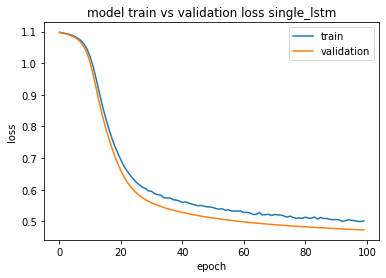

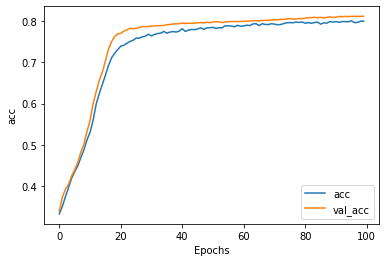

#######################################################
F1        : 0.8073563575744629
Precision : 0.8466997742652893
Recall    : 0.7726902961730957
Accuracy  : 0.8116260170936584
#######################################################
-------------------------------------
#######################################################
F1        : 0.7996760606765747
Precision : 0.8413379192352295
Recall    : 0.7633928656578064
Accuracy  : 0.802395224571228
#######################################################
-------------------------------------
#######################################################
F1        : 0.8017594814300537
Precision : 0.8407090306282043
Recall    : 0.7665550708770752
Accuracy  : 0.7944111824035645
#######################################################
-------------------------------------
#######################################################
F1        : 0.7925722002983093
Precision : 0.8246829509735107
Recall    : 0.763485848903656
Accuracy  : 0.7984032034873962


In [ ]:
single_lstm_fastText(64, activation = 'tanh', 
            dropout = 0.2, 
            dense_actv ='softmax',
            epochs =100,
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

In [ ]:
#second run
single_lstm(64, activation = 'tanh', 
            dropout = 0.2, 
            dense_actv ='softmax',
            epochs =100,
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

# Double layer LSTM with fast text emb.


In [ ]:
def double_lstm_ft(nodes, **kwargs):
  #as declared above earlier
  MAX_NB_WORDS = 15000
  EMBEDDING_DIM = 100
  MAX_SEQ_LENGTH = 12
  with tf.device('/device:GPU:0'):
    model_d_ft = Sequential()

    #embedding for fasttext is 300
    model_d_ft.add(Embedding(MAX_NB_WORDS, 300,
          weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False))

    model_d_ft.add(LSTM(nodes, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout'), return_sequences=True ))
    model_d_ft.add(LSTM(64, activation=  kwargs.get('activation'), dropout=  kwargs.get('dropout') ))
    model_d_ft.add(Dense(30,activation= kwargs.get('dense_actv')))
    model_d_ft.add(Dense(3, activation= kwargs.get('dense_actv')))

    optimizer = Adam(learning_rate=1e-5)
    
    model_d_ft.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=['acc',f1_m,precision_m, recall_m])
    model_d_ft.summary()
    history = model_d_ft.fit(kwargs.get('X_train'), 
                        kwargs.get('Y_train'), 
                        epochs= kwargs.get('epochs'), 
                        batch_size = 100,
                        validation_data=(kwargs.get('X_test'), kwargs.get('Y_test')),)
    display_history_loss(history, "double_lstm_ft")
    plot_graphs(history, "acc")
    loss, acc, f1_score, precision, recall = model_d_ft.evaluate(X_test, Y_test,  verbose=0 )
    print_stats(f1_score, precision, recall, acc)
    custom_evaluate(model_d_ft, X1_test,Y1_test)
    custom_evaluate(model_d_ft, X2_test,Y2_test)
    custom_evaluate(model_d_ft, X3_test,Y3_test)
    custom_evaluate(model_d_ft, X4_test,Y4_test)
    custom_evaluate(model_d_ft, X5_test,Y5_test)
    

## Result

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 12, 300)           4500000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 12, 64)            93440     
_________________________________________________________________
lstm_24 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_60 (Dense)             (None, 30)                1950      
_________________________________________________________________
dense_61 (Dense)             (None, 3)                 93        
Total params: 4,628,507
Trainable params: 128,507
Non-trainable params: 4,500,000
_________________________________________________________________
Epoch 1/200
146/146 [==============================] - 2s 13ms/step - loss: 1.0991 - acc: 0.3338 - f1_m

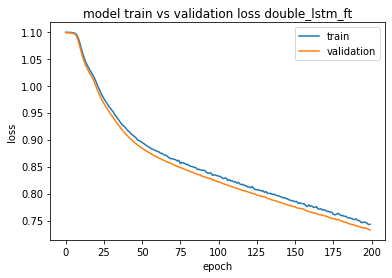

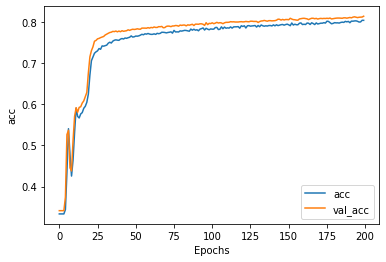

#######################################################
F1        : 0.8018614649772644
Precision : 0.8508782386779785
Recall    : 0.7595235705375671
Accuracy  : 0.813271164894104
#######################################################
-------------------------------------
#######################################################
F1        : 0.789384663105011
Precision : 0.8437224626541138
Recall    : 0.7428385615348816
Accuracy  : 0.8003991842269897
#######################################################
-------------------------------------
#######################################################
F1        : 0.7874987125396729
Precision : 0.8397098779678345
Recall    : 0.7420945167541504
Accuracy  : 0.796407163143158
#######################################################
-------------------------------------
#######################################################
F1        : 0.7833897471427917
Precision : 0.8143520951271057
Recall    : 0.755673348903656
Accuracy  : 0.7884231805801392
##

In [ ]:
double_lstm_ft(64, activation = 'tanh',  
            dense_actv ='softmax',
            epochs =200, 
            dropout=0.2,
            X_train = X_train,
            Y_train = Y_train,
            X_test = X_test,
            Y_test = Y_test)

#Bi-Directional LSTM with Fasttext emb


In [44]:
MAX_NB_WORDS = 15000
model_bi_ft = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, 300,  weights=[embedding_matrix], input_length=12, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    #tf.keras.layers.Dense(30, activation='softmax'),
    # Add a Dense layer with 3 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(3, activation='softmax')
])
model_bi_ft.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 12, 300)           4500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 4,585,443
Trainable params: 85,443
Non-trainable params: 4,500,000
_________________________________________________________________


In [45]:
#model2.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    
model_bi_ft.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])
with tf.device('/device:GPU:0'):
   history_bi_ft = model_bi_ft.fit(
      X_train, Y_train, epochs=200,batch_size = 100,callbacks=[es], validation_data=(X_test, Y_test),
  )


Epoch 1/200
146/146 [==============================] - 2s 14ms/step - loss: 1.0983 - acc: 0.3495 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0970 - val_acc: 0.3869 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/200
146/146 [==============================] - 1s 8ms/step - loss: 1.0956 - acc: 0.3955 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0944 - val_acc: 0.4187 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/200
146/146 [==============================] - 1s 8ms/step - loss: 1.0929 - acc: 0.4258 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.0915 - val_acc: 0.4327 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
146/146 [==============================] - 1s 8ms/step - loss: 1.0899 - acc: 0.4492 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0

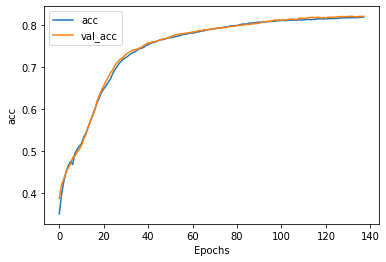

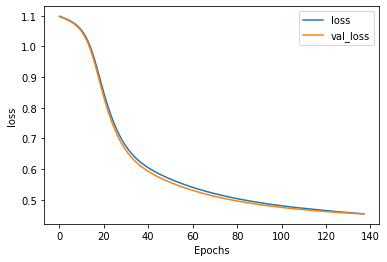

In [46]:
plot_graphs(history_bi_ft, "acc")
plot_graphs(history_bi_ft, "loss")  

## Result


In [47]:
custom_evaluate(model_bi_ft,X1_test,Y1_test)
custom_evaluate(model_bi_ft,X2_test,Y2_test)
custom_evaluate(model_bi_ft,X3_test,Y3_test)
custom_evaluate(model_bi_ft,X4_test,Y4_test)
custom_evaluate(model_bi_ft,X5_test,Y5_test)

-------------------------------------
#######################################################
F1        : 0.8124290108680725
Precision : 0.8381474614143372
Recall    : 0.788876473903656
Accuracy  : 0.8243513107299805
#######################################################
-------------------------------------
#######################################################
F1        : 0.8409782648086548
Precision : 0.8656672239303589
Recall    : 0.818173348903656
Accuracy  : 0.8483033776283264
#######################################################
-------------------------------------
#######################################################
F1        : 0.8048156499862671
Precision : 0.8374950885772705
Recall    : 0.7752976417541504
Accuracy  : 0.802395224571228
#######################################################
-------------------------------------
#######################################################
F1        : 0.7958805561065674
Precision : 0.82383793592453
Recall    : 0.7702752947807

# Transformer Custom with Fasttext emb
    

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers as tfopt

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim,  weights=[embedding_matrix],  trainable=False)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
#keras.backend.clear_session()
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block =  TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.20)(x)
x = layers.Dense(20, activation="softmax")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model_transformer_ft = keras.Model(inputs=inputs, outputs=outputs)

## Result

In [ ]:
with tf.device('/device:GPU:0'):
  optimizer_t = tfopt.Adam(learning_rate=1e-5)
  model_transformer_ft.compile(loss="categorical_crossentropy", optimizer=optimizer_t,  metrics=['acc',f1_m,precision_m, recall_m]
)
  model_transformer_ft.summary()  
  history_transformer_ft = model_transformer_ft.fit(
      X_train, Y_train, batch_size=100, epochs=200, validation_data=(X_test, Y_test)
  )

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
token_and_position_embedding (None, 12, 300)           4503600   
_________________________________________________________________
transformer_block_6 (Transfo (None, 12, 300)           381932    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 20)                6020      
_________________________________________________________________
dropout_17 (Dropout)         (None, 20)               

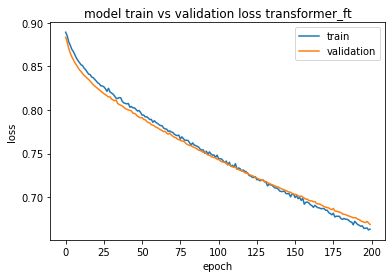

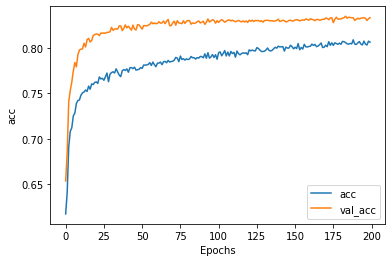

In [ ]:
display_history_loss(history_transformer_ft, "transformer_ft")
plot_graphs(history_transformer_ft, "acc")

In [ ]:
print(X_test.shape)

#score_transformer = model_transformer.evaluate(X_test,Y_test)
#print(score_transformer[0])
#print(score_transformer[1])

loss, acc, f1_score, precision, recall = model_transformer_ft.evaluate(X_test, Y_test,  verbose=0 )
print_stats(f1_score, precision, recall, acc)
custom_evaluate(model_transformer_ft, X1_test,Y1_test)
custom_evaluate(model_transformer_ft, X2_test,Y2_test)
custom_evaluate(model_transformer_ft, X3_test,Y3_test)
custom_evaluate(model_transformer_ft, X4_test,Y4_test)
custom_evaluate(model_transformer_ft, X5_test,Y5_test)

(3647, 12)
#######################################################
F1        : 0.830353319644928
Precision : 0.8500233888626099
Recall    : 0.8121816515922546
Accuracy  : 0.833836019039154
#######################################################
-------------------------------------
#######################################################
F1        : 0.8207497000694275
Precision : 0.8401288986206055
Recall    : 0.8024553656578064
Accuracy  : 0.8243513107299805
#######################################################
-------------------------------------
#######################################################
F1        : 0.8129767775535583
Precision : 0.8339003920555115
Recall    : 0.7938057780265808
Accuracy  : 0.8103792667388916
#######################################################
-------------------------------------
#######################################################
F1        : 0.8081247210502625
Precision : 0.8254852294921875
Recall    : 0.7917596697807312
Accuracy  : 0.810379

#Statistical Test

## Annova Test

In [17]:
#manually filled f1 from results above. for all the sets 1-5 and X_test Y_test.

lstm_single_f1_ft =[0.8073,0.7996,0.8017,0.7925,0.8226,0.8014]
lstm_double_f1_ft =[0.8018,0.7893,0.7874,0.7833,0.8360,0.7974]
lstm_bi_f1_ft =[0.8124,0.8409,0.8048,0.7958,0.8283,0.8142]
transformer_f1_ft=[0.8303, 0.8207, 0.8129, 0.8081,0.8469,0.8239]


#f1 score
lstm_single_f1 = [0.8285,0.8118,0.8004,0.8163,0.8336,0.8389]
lstm_double_f1 = [0.8801,0.8787,0.8606,0.8676,0.8709,0.8873]
lstm_bi_f1 = [0.8840, 0.8611,0.8293,0.8590,0.8844,0.8756]  
transformer_f1 = [0.87743,0.87425,0.84231,0.86626,0.88622, 0.86826]



data_f1_ft = {'lstm_single_f1_ft':lstm_single_f1_ft,'lstm_double_f1_ft':lstm_double_f1_ft,'lstm_bi_f1_ft':lstm_bi_f1_ft,'transformer_f1_ft':transformer_f1_ft}
#d_ft_normal = {'lstm_single_acc_ft':lstm_single_acc_ft,'lstm_single_acc':lstm_single_acc}
data_f1 = {'lstm_single_f1':lstm_single_f1,'lstm_double_f1':lstm_double_f1,'lstm_bi_f1':lstm_bi_f1,'transformer_f1':transformer_f1}

data_f1_transformer_keras_ft = {'transformer_f1_ft':transformer_f1_ft,'transformer_f1':transformer_f1}
import pandas as pd

#fasttext
df_f1_ft = pd.DataFrame(data_f1_ft)
#df_ft_normal = pd.DataFrame(d_ft_normal)
#keras
df_data_f1 = pd.DataFrame(data_f1)

df_data_f1_transformer_keras_ft = pd.DataFrame(data_f1_transformer_keras_ft)


In [18]:
df_data_f1

,lstm_single_f1,lstm_double_f1,lstm_bi_f1,transformer_f1
0,0.8285,0.8801,0.8840,0.87743
1,0.8118,0.8787,0.8611,0.87425
2,0.8004,0.8606,0.8293,0.84231
3,0.8163,0.8676,0.8590,0.86626
4,0.8336,0.8709,0.8844,0.88622
5,0.8389,0.8873,0.8756,0.86826


In [19]:
df_f1_ft

,lstm_single_f1_ft,lstm_double_f1_ft,lstm_bi_f1_ft,transformer_f1_ft
0,0.8073,0.8018,0.8124,0.8303
1,0.7996,0.7893,0.8409,0.8207
2,0.8017,0.7874,0.8048,0.8129
3,0.7925,0.7833,0.7958,0.8081
4,0.8226,0.8360,0.8283,0.8469
5,0.8014,0.7974,0.8142,0.8239


In [20]:
#Annova test 
import scipy.stats as stats


In [22]:
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(df_data_f1['lstm_single_f1'], df_data_f1['lstm_double_f1'], df_data_f1['lstm_bi_f1'], df_data_f1['transformer_f1'])
print(fvalue, pvalue)
if(pvalue < 0.05):
  print("reject null hypothesis for all models are same keras embedding")

# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(df_f1_ft['lstm_single_f1_ft'], df_f1_ft['lstm_double_f1_ft'], df_f1_ft['lstm_bi_f1_ft'], df_f1_ft['transformer_f1_ft'])
print(fvalue, pvalue)
if(pvalue < 0.05):
  print("reject null hypothesis for all models are same fasttext embedding")


# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(df_data_f1_transformer_keras_ft['transformer_f1_ft'], df_data_f1_transformer_keras_ft['transformer_f1'])
print(fvalue, pvalue)
if(pvalue < 0.05):
  print("reject null hypothesis for transformer_ft and transformer keras are same")




14.681757458483455 2.7610079338515238e-05
reject null hypothesis for all models are same keras embedding
3.2290129092003705 0.04425615093081563
reject null hypothesis for all models are same fasttext embedding
29.822798330866977 0.0002765273912889113
reject null hypothesis for transformer_ft and transformer keras are same


In [7]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(df_data_f1.reset_index(), id_vars=['index'], value_vars=['lstm_single_f1', 'lstm_double_f1', 'lstm_bi_f1', 'transformer_f1'])
# replace column names
d_melt.columns = ['index', 'models', 'value']
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(models)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,sum_sq,df,F,PR(>F)
C(models),0.010614,3.0,14.681757,0.000028
Residual,0.004820,20.0,NaN,NaN


The P-value obtained from ANOVA analysis is significant (P<0.05), and therefore, we conclude that there are significant differences among acc.


In [8]:
!pip install pingouin

     |████████████████████████████████| 225kB 6.9MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.7-cp36-none-any.whl size=217260 sha256=b8b52dd189f3aa27c3f72a351b63fe98394d88f8e9bd6e93163d87d20facba94
  Stored in directory: /root/.cache/pip/wheels/02/92/32/0ed9ac4a9407227f3f070170a26d05f07d6f2a8a68989a8ac3
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4962 sha256=c58acfd8295dd0047902387a516cab2d57320a52f2892c88a664cca62df9814f
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7049 sha256=3baf4ff98ef54c0ed33d06d3620e0780bd3a4b0aa9ca880e043fe61395c2b563
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


From ANOVA analysis, we know that model acc differences are statistically significant, but ANOVA does not tell which models are significantly different from each other. To know the pairs of significant different, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test


## Turkey Test

In [9]:
# load packages
from pingouin import pairwise_tukey
# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt, dv='value', between='models')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,lstm_bi_f1,lstm_double_f1,0.865567,0.874200,-0.008633,0.008962,-0.963279,0.742635,-0.513369
1,lstm_bi_f1,lstm_single_f1,0.865567,0.821583,0.043983,0.008962,4.907518,0.001000,2.615406
2,lstm_bi_f1,transformer_f1,0.865567,0.869122,-0.003555,0.008962,-0.396655,0.900000,-0.211393
3,lstm_double_f1,lstm_single_f1,0.874200,0.821583,0.052617,0.008962,5.870797,0.001000,3.128775
4,lstm_double_f1,transformer_f1,0.874200,0.869122,0.005078,0.008962,0.566624,0.900000,0.301976
5,lstm_single_f1,transformer_f1,0.821583,0.869122,-0.047538,0.008962,-5.304173,0.001000,-2.826799


Above results from Tukey HSD suggests that 


---


except (lstm_bi and lstm_double) (lstm_bi and transformer) (lstm_double and transformer)


---


all other pairwise comparisons for treatments rejects null hypothesis (P-tukey<0.05) and indicates statistical significant differences.

In [10]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt_ft = pd.melt(df_f1_ft.reset_index(), id_vars=['index'], value_vars=['lstm_single_f1_ft', 'lstm_double_f1_ft', 'lstm_bi_f1_ft', 'transformer_f1_ft'])
# replace column names
d_melt_ft.columns = ['index', 'models', 'value']
# Ordinary Least Squares (OLS) model
model_ft = ols('value ~ C(models)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model_ft, typ=2)
anova_table

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

,sum_sq,df,F,PR(>F)
C(models),0.010614,3.0,14.681757,0.000028
Residual,0.004820,20.0,NaN,NaN


In [11]:

# perform multiple pairwise comparison (Tukey HSD)
# for unbalanced (unequal sample size) data, pairwise_tukey uses Tukey-Kramer test
m_comp = pairwise_tukey(data=d_melt_ft, dv='value', between='models')
m_comp

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,lstm_bi_f1_ft,lstm_double_f1_ft,0.816067,0.799200,0.016867,0.0088,1.916679,0.229693,1.021472
1,lstm_bi_f1_ft,lstm_single_f1_ft,0.816067,0.804183,0.011883,0.0088,1.350387,0.526376,0.719674
2,lstm_bi_f1_ft,transformer_f1_ft,0.816067,0.823800,-0.007733,0.0088,-0.878793,0.789833,-0.468343
3,lstm_double_f1_ft,lstm_single_f1_ft,0.799200,0.804183,-0.004983,0.0088,-0.566291,0.900000,-0.301799
4,lstm_double_f1_ft,transformer_f1_ft,0.799200,0.823800,-0.024600,0.0088,-2.795472,0.032688,-1.489815
5,lstm_single_f1_ft,transformer_f1_ft,0.804183,0.823800,-0.019617,0.0088,-2.229181,0.125215,-1.188017


The avobe results for fatstext models outlines that double LSTM and Transformer have a significant difference.